# How to create custom dataset



In [1]:
import numpy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

SEED = 1

# CUDA
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Create the image folder and the loaders



In [2]:
# Here we add all the transformation we want to apply to our images
#Grayscale in order to make it faster (we dont take colors into account)
#Flip and rotation in order data augmentation to our classifier 
transformations = transforms.Compose([transforms.Grayscale(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.ToTensor()
])
image_data = datasets.ImageFolder('PPC2',transformations)

### Split the data_set into a train and test dataset where 80% of the data as are used for training.
train_size = int(0.8 * len(image_data))
test_size = len(image_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_data, [train_size, test_size])

#print (train_dataset)
#print (train_size)
#print (test_size)

In [3]:
# Loading datas 4 by 4 
dataloader_args = dict(shuffle=True, batch_size=4,num_workers=4, pin_memory=True)
train_loader = dataloader.DataLoader(train_dataset, **dataloader_args)
# Loading the test datas in one step 
dataloader_args = dict(shuffle=True, batch_size=len(test_dataset),num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test_dataset, **dataloader_args)




# Build the model



In [4]:
# Two hidden Layers NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc0 = nn.Linear(32 * 32, 16*16) # Input layer (1024) , fc = fully connected layer 
        #self.fc1 = nn.Linear(1000, 3)
        self.fc1 = nn.Linear(16 * 16, 8*8) # hidden Layer #1 (256)-> #hidden Layer #2 (64)
        self.fc2 = nn.Linear(8*8, 3)# Output Layer (3)
    def forward(self, x):
        #out = self.drop_out(out)
        x = x.view((-1, 1024))
        h = F.selu(self.fc0(x))
        h = F.selu(self.fc1(h))
        out = self.fc2(h)
        return F.log_softmax(out)    
    
    
model = Model()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
EPOCHS = 300
losses = []


# iterate on the the test loader in order to get the Tensor needed to evaluate our trained model
dataiter = iter(test_loader)
images, labels = dataiter.next()

#model.eval()
#print (images.shape)
#output = model(images)
    
train_size = len(train_loader.dataset)
batch_size = (train_size / 4) 

#  Train & Test



In [9]:

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        

        
        # Init
        optimizer.zero_grad()
        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 4 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
            
    # display final evaluation for this epoch
    model.eval()
    output = model(images)
    pred = output.data.max(1)[1]
    d = pred.eq(labels.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

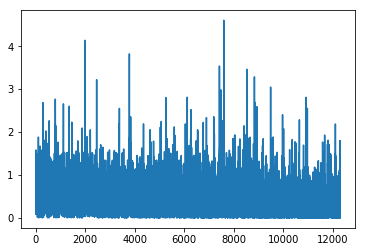

In [26]:
plt.plot(losses)